In [35]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import re

In [36]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
from tensorflow.keras.utils import plot_model
from nltk.translate.bleu_score import sentence_bleu

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

In [39]:
images_list,features_list=pickle.load(open('/content/drive/MyDrive/ Image_captioning/image_and_feature_1.pkl','rb')) #load image and features

#create data frame of images and features
d={'image':images_list,'features':features_list}
df_features = pd.DataFrame(d, columns = ['image','features'], index=[i for i in range(len(images_list))])

print(df_features.shape)
df_features.head(5)

(8091, 2)


image                                           features
0   375392855_54d46ed5c8.jpg  [0.11761571, 0.010827985, 0.00094755075, 0.0, ...
1  3744832122_2f4febdff6.jpg  [0.0, 0.0, 0.003859377, 0.0, 0.0, 0.0, 0.0, 0....
2  3745451546_fc8ec70cbd.jpg  [0.21418853, 0.0, 0.0, 0.420549, 0.2193998, 0....
3  3751594676_edfbfa0688.jpg  [0.089692056, 0.00057345943, 0.15897064, 0.009...
4  3760400645_3ba51d27f9.jpg  [0.30306783, 0.03667612, 0.0, 0.0, 0.501048, 0...

In [40]:
df_text=pd.read_csv('/content/drive/MyDrive/ Image_captioning/data.csv')
df_text.head()

image  ...                                             output
0  1000268201_693b08cb0e.jpg  ...  child in pink dress is climbing up set of stai...
1  1000268201_693b08cb0e.jpg  ...        girl going into wooden building <end> <end>
2  1000268201_693b08cb0e.jpg  ...  little girl climbing into wooden playhouse <en...
3  1000268201_693b08cb0e.jpg  ...  little girl climbing the stairs to her playhou...
4  1000268201_693b08cb0e.jpg  ...  little girl in pink dress going into wooden ca...

[5 rows x 3 columns]

In [41]:
path='/content/drive/MyDrive/ Image_captioning/ text_dataset/Flickr8k_text/Flickr_8k.trainImages.txt'
with open(path, encoding="utf8", errors='ignore') as f:
         training_images=f.readlines()
path='/content/drive/MyDrive/ Image_captioning/ text_dataset/Flickr8k_text/Flickr_8k.devImages.txt'
with open(path, encoding="utf8", errors='ignore') as f:
         crossvalidating_images=f.readlines()
path='/content/drive/MyDrive/ Image_captioning/ text_dataset/Flickr8k_text/Flickr_8k.testImages.txt'
with open(path, encoding="utf8", errors='ignore') as f:
         testing_images=f.readlines()

In [42]:
#process all image names
def process_images(images):
    t_images=[]
    for i in range(len(images)):
      s=re.sub('\n','',images[i])#remoe \n from image names
      t_images.append(s)
    return t_images

In [43]:
#get all images belonging to respective group
train_images=process_images(training_images)
cv_images=process_images(crossvalidating_images)
test_images=process_images(testing_images)

In [44]:
def data_frame(images):
  d={'image':images}
  df_t=pd.DataFrame(d, columns = ['image'], index=[i for i in range(len(images))])
  df3=pd.merge(df_text,df_t) #merge text data and image data
  df4=pd.merge(df3,df_features) #merge new data frame with featuree to create train,test and cv data frames
  return df4

In [45]:
train_df=data_frame(train_images)
print(train_df.shape)

(28585, 4)


In [46]:
cv_df=data_frame(cv_images)
print(cv_df.shape)

(4737, 4)


In [47]:
test_df=data_frame(test_images)
print(test_df.shape)

(4772, 4)


In [48]:
tknizer_= Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_.fit_on_texts(train_df['input'].values)

vocab_size = len(tknizer_.word_index) + 1
max_len=15+2
vocab_size,max_len

(7032, 17)

In [49]:
def reshape(X):
  x_r=np.zeros((X.shape[0],2048))
  for i in range(X.shape[0]):
    x_r[i]=X[i].reshape(1,2048)
  return x_r

In [50]:
X1_train_input=reshape(train_df['features'])
X2_train_input=tknizer_.texts_to_sequences(train_df['input'])
y_train_output=tknizer_.texts_to_sequences(train_df['output'])

X1_cv_input=reshape(cv_df['features'])
X2_cv_input=tknizer_.texts_to_sequences(cv_df['input'])
y_cv_output=tknizer_.texts_to_sequences(cv_df['output'])

X1_test_input=reshape(test_df['features'])
X2_test_input=tknizer_.texts_to_sequences(test_df['input'])
y_test_output=tknizer_.texts_to_sequences(test_df['output'])

In [51]:
X2_train_input=pad_sequences(X2_train_input,maxlen=max_len,padding='post')
y_train_output=pad_sequences(y_train_output,maxlen=max_len,padding='post')

X2_cv_input=pad_sequences(X2_cv_input,maxlen=max_len,padding='post')
y_cv_output=pad_sequences(y_cv_output,maxlen=max_len,padding='post')

X2_test_input=pad_sequences(X2_test_input,maxlen=max_len,padding='post')
y_test_output=pad_sequences(y_test_output,maxlen=max_len,padding='post')

In [52]:
print(X1_train_input.shape,X2_train_input.shape,y_train_output.shape)
print(X1_cv_input.shape,X2_cv_input.shape,y_cv_output.shape)
print(X1_test_input.shape,X2_test_input.shape,y_test_output.shape)

(28585, 2048) (28585, 17) (28585, 17)
(4737, 2048) (4737, 17) (4737, 17)
(4772, 2048) (4772, 17) (4772, 17)


In [53]:
def generate_batch(X_img,X_txt,y_txt,batch_size):
    while True:
        for i in range(0,X_img.shape[0]//batch_size):
            input_img = X_img[i*batch_size:(i+1)*batch_size]
            input_txt = X_txt[i*batch_size:(i+1)*batch_size]
            output_ind= y_txt[i*batch_size:(i+1)*batch_size]
            output_txt=np.zeros((batch_size,max_len,vocab_size))
            for i in range(batch_size):
                for j in range(max_len):
                    k=output_ind[i][j]
                    if k!=0:
                        output_txt[i][j][k]=1
                    else:
                        continue
            yield([input_img,input_txt],output_txt) 

In [54]:
embedding_dim=150
lstm_units=X1_train_input.shape[1]

In [55]:
# Encoder
# encoder_inputs = Input(batch_shape=(batch_size,max_len_eng))
encoder_inputs = Input(shape=(None,),name='Encoder_input')
print('Encoder input : ',encoder_inputs.shape)
encoder_states = [encoder_inputs,encoder_inputs]

Encoder input :  (None, None)


In [56]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,),name='Decoder_input')
print('Decoder inputs : ',decoder_inputs.shape)
dec_emb_layer = Embedding(vocab_size,embedding_dim,name='Decoder_embedding_layer')
dec_emb = dec_emb_layer(decoder_inputs)
print('Decoder after embedding layer : ',dec_emb.shape)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True,name='Decoder_lstm_layer')
decoder_outputs, _, _ = decoder_lstm(dec_emb,initial_state=encoder_states)
print('Decoder outputs after lstm : ',decoder_outputs.shape)
decoder_dense = Dense(vocab_size , activation='softmax',name='Decoder_dense_layer')
decoder_outputs = decoder_dense(decoder_outputs)
print('Decoder outputs after dense layer : ',decoder_outputs.shape)
print('-'*40)
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

Decoder inputs :  (None, None)
Decoder after embedding layer :  (None, None, 150)
Decoder outputs after lstm :  (None, None, 2048)
Decoder outputs after dense layer :  (None, None, 7032)
----------------------------------------


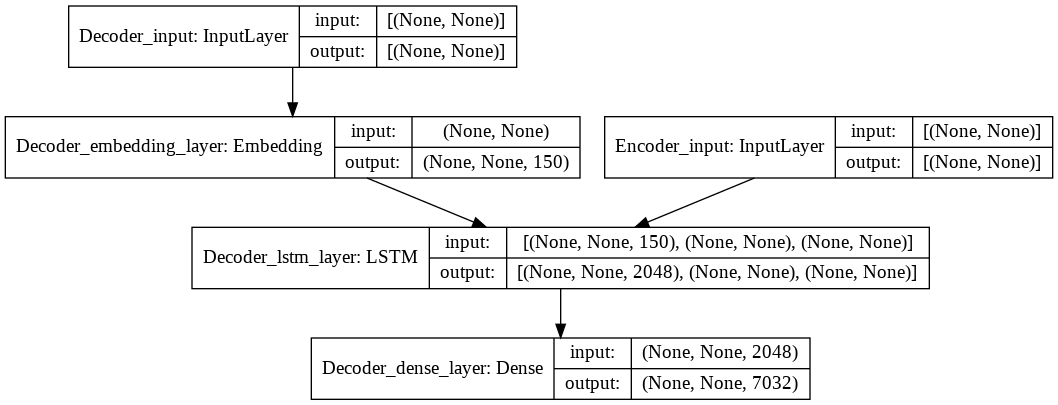

In [57]:
plot_model(model,'model_encoder_decoder.png',show_shapes=True)

In [58]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [59]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',min_delta=0.01,patience=4,restore_best_weights=True,mode='min')
model_checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/ Image_captioning/model_1.h5',mode='max',save_best_only=True)
cb=[early_stopping,model_checkpoint]

In [60]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
Decoder_embedding_layer (Embedd (None, None, 150)    1054800     Decoder_input[0][0]              
__________________________________________________________________________________________________
Encoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
Decoder_lstm_layer (LSTM)       [(None, None, 2048), 18014208    Decoder_embedding_layer[0][0]    
                                                                 Encoder_input[0][0]        

In [61]:
train_samples = len(X1_train_input)
val_samples = len(X1_cv_input)
epochs = 50
batch_size=64

In [62]:
hs=model.fit_generator(generator = generate_batch(X1_train_input,X2_train_input,y_train_output, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X1_cv_input,X2_cv_input,y_cv_output, batch_size = batch_size),
                    validation_steps = val_samples//batch_size,callbacks=cb)

Epoch 1/50
446/446 [==============================] - 83s 180ms/step - loss: 3.2899 - val_loss: 2.3902
Epoch 2/50
446/446 [==============================] - 79s 178ms/step - loss: 2.2987 - val_loss: 2.2103
Epoch 3/50
446/446 [==============================] - 79s 178ms/step - loss: 2.0640 - val_loss: 2.1606
Epoch 4/50
446/446 [==============================] - 79s 178ms/step - loss: 1.8967 - val_loss: 2.1633
Epoch 5/50
446/446 [==============================] - 79s 178ms/step - loss: 1.7496 - val_loss: 2.1974
Epoch 6/50
446/446 [==============================] - 79s 178ms/step - loss: 1.6107 - val_loss: 2.2527
Epoch 7/50
446/446 [==============================] - 79s 178ms/step - loss: 1.4823 - val_loss: 2.3284


In [63]:
model.save_weights('/content/drive/MyDrive/ Image_captioning/model_50.h5')

In [64]:
model.load_weights('/content/drive/MyDrive/ Image_captioning/model_50.h5')

Text(0.5, 1.0, 'Loss vs validation Loss')

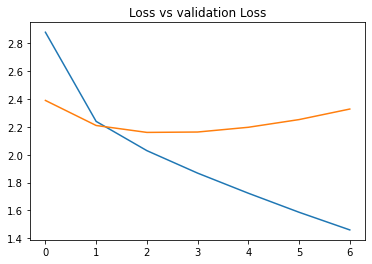

In [65]:
h=hs.history
plt.plot(h['loss'])
plt.plot(h['val_loss'])
plt.title('Loss vs validation Loss')

In [66]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)
 
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(lstm_units,),name='Decoder_state_h')
decoder_state_input_c = Input(shape=(lstm_units,),name='Decoder_state_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [67]:
encoder_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder_input (InputLayer)   [(None, None)]            0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


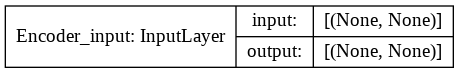

In [68]:
plot_model(encoder_model,'model_encoder_decoder.png',show_shapes=True)

In [69]:
decoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
Decoder_embedding_layer (Embedd (None, None, 150)    1054800     Decoder_input[0][0]              
__________________________________________________________________________________________________
Decoder_state_h (InputLayer)    [(None, 2048)]       0                                            
__________________________________________________________________________________________________
Decoder_state_c (InputLayer)    [(None, 2048)]       0                                            
____________________________________________________________________________________________

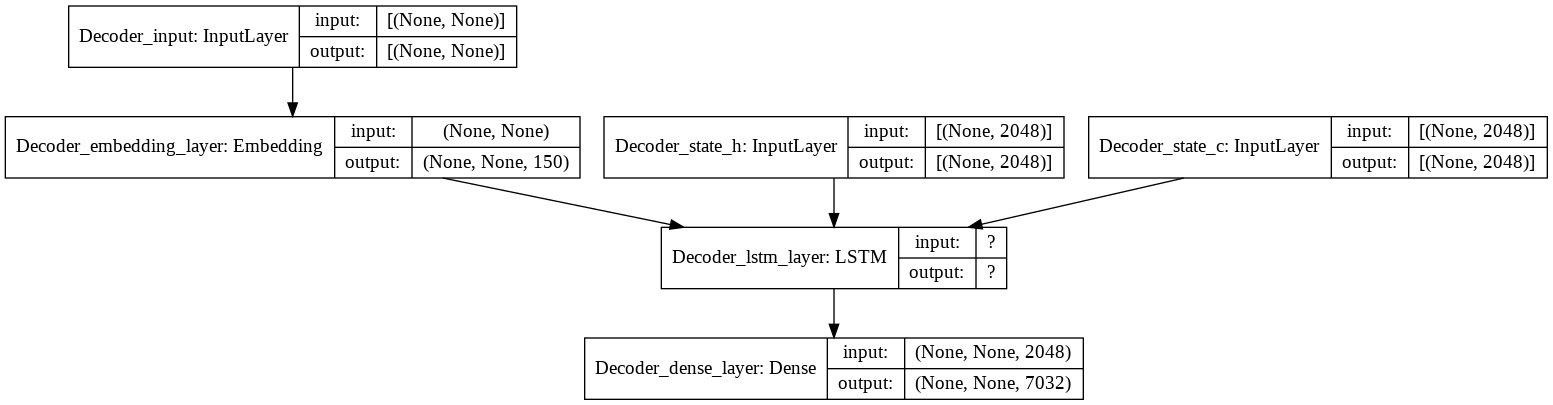

In [70]:
plot_model(decoder_model,'model_encoder_decoder.png',show_shapes=True)

In [71]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = tknizer_.word_index['<start>']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = tknizer_.index_word[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '<end>'):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [72]:
def index_to_text(x):#convert id to word
    s=''
    for i in x[0]:
        if i==0:
            break
        if tknizer_.index_word[i]=='<end>' or tknizer_.index_word[i]=='<start>':
            continue
        s+=tknizer_.index_word[i]+' '
    return s

In [85]:
def print_image_and_text(df,count,gen):
    i=0
    for c in range(count):
      img=df['image'][i]
      while df['image'][i]==img:
        (input_seq, actual_output), _ = next(gen)
        print('Actual    sentance  : ',index_to_text(actual_output))
        i+=1
      decoded_sentence = decode_sequence(input_seq)

      path='/content/drive/MyDrive/ Image_captioning/ image_dataset/Flicker8k_Dataset'
      image=load_img(path+"/"+img,target_size=(229,229))
      image_array=img_to_array(image)/255
      plt.imshow(image_array)
      plt.show()

      print('Predicted sentance : ',decoded_sentence)
      print('='*100)
    return

# Sample Texts and Images from Train set

Actual    sentance  :  child in pink dress is climbing up set of stairs in an entry way 
Actual    sentance  :  girl going into wooden building 
Actual    sentance  :  little girl climbing into wooden playhouse 
Actual    sentance  :  little girl climbing the stairs to her playhouse 
Actual    sentance  :  little girl in pink dress going into wooden cabin 


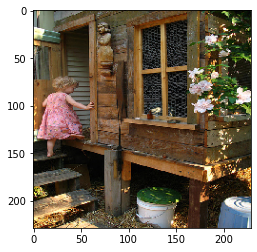

Predicted sentance :   woman and woman are sitting on table <end>
Actual    sentance  :  black dog and spotted dog are fighting 
Actual    sentance  :  black dog and tri colored dog playing with each other on the road 
Actual    sentance  :  two dogs of different breeds looking at each other on the road 
Actual    sentance  :  two dogs on pavement moving toward each other 


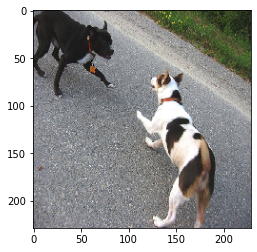

Predicted sentance :   two dogs play in the grass <end>
Actual    sentance  :  little girl is sitting in front of large painted rainbow 
Actual    sentance  :  there is girl with pigtails sitting in front of rainbow painting 
Actual    sentance  :  young girl with pigtails painting outside in the grass 


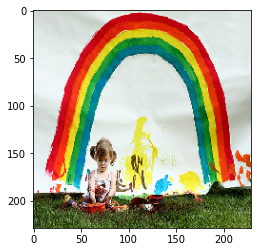

Predicted sentance :   two children play in the air <end>
Actual    sentance  :  man lays on bench while his dog sits by him 
Actual    sentance  :  man lays on the bench to which white dog is also tied 
Actual    sentance  :  man sleeping on bench outside with white and black dog sitting next to him 
Actual    sentance  :  shirtless man lies on park bench with his dog 
Actual    sentance  :  man laying on bench holding leash of dog sitting on ground 


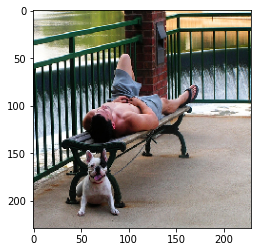

Predicted sentance :   man sits on bench with an orange shirt <end>
Actual    sentance  :  man in an orange hat starring at something 
Actual    sentance  :  man wears an orange hat and glasses 
Actual    sentance  :  man with gauges and glasses is wearing blitz hat 
Actual    sentance  :  man with glasses is wearing beer can crocheted hat 
Actual    sentance  :  the man with pierced ears is wearing glasses and an orange hat 


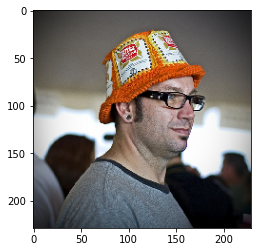

Predicted sentance :   man with glasses and hat is sitting on the street <end>
Actual    sentance  :  child playing on rope net 
Actual    sentance  :  little girl climbing on red roping 
Actual    sentance  :  little girl in pink climbs rope bridge at the park 
Actual    sentance  :  small child grips onto the red ropes at the playground 
Actual    sentance  :  the small child climbs on red ropes on playground 


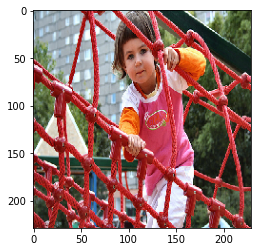

Predicted sentance :   two children play on the floor <end>
Actual    sentance  :  black and white dog is running in grassy garden surrounded by white fence 
Actual    sentance  :  black and white dog is running through the grass 
Actual    sentance  :  boston terrier is running in the grass 
Actual    sentance  :  boston terrier is running on lush green grass in front of white fence 
Actual    sentance  :  dog runs on the green grass near wooden fence 


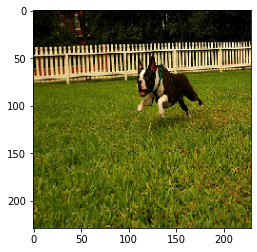

Predicted sentance :   dog runs through the grass <end>
Actual    sentance  :  dog shakes its head near the shore red ball next to it 
Actual    sentance  :  white dog shakes on the edge of beach with an orange ball 
Actual    sentance  :  dog with orange ball at feet stands on shore shaking off water 
Actual    sentance  :  white dog playing with red ball on the shore near the water 
Actual    sentance  :  white dog with brown ears standing near water with head turned to one side 


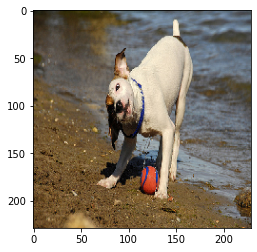

Predicted sentance :   white dog is running through the grass <end>
Actual    sentance  :  boy smiles in front of stony wall in city 
Actual    sentance  :  young boy runs aross the street 
Actual    sentance  :  young child is walking on stone paved street with metal pole and man behind him 


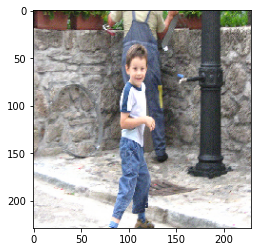

Predicted sentance :   two children play in the air <end>
Actual    sentance  :  black dog leaps over log 
Actual    sentance  :  grey dog is leaping over fallen tree 
Actual    sentance  :  large black dog leaps fallen log 
Actual    sentance  :  mottled black and grey dog in blue collar jumping over fallen tree 
Actual    sentance  :  the black dog jumped the tree stump 


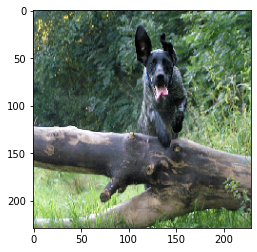

Predicted sentance :   dog with red collar runs through the grass <end>
Actual    sentance  :  brown and white dog is running through the snow 
Actual    sentance  :  dog is running in the snow 
Actual    sentance  :  dog running through snow 
Actual    sentance  :  white and brown dog is running through snow covered field 
Actual    sentance  :  the white and brown dog is running over the surface of the snow 


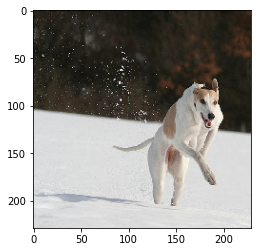

Predicted sentance :   white dog is running through the snow <end>
Actual    sentance  :  man in hat is displaying pictures next to skier in blue hat 
Actual    sentance  :  man skis past another man displaying paintings in the snow 
Actual    sentance  :  person wearing skis looking at framed pictures set up in the snow 
Actual    sentance  :  skier looks at framed pictures in the snow next to trees 
Actual    sentance  :  man on skis looking at artwork for sale in the snow 


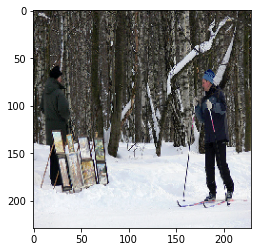

Predicted sentance :   man in red and white pants is walking through the snow <end>
Actual    sentance  :  collage of one person climbing cliff 
Actual    sentance  :  group of people are rock climbing on rock climbing wall 
Actual    sentance  :  group of people climbing rock while one man belays 
Actual    sentance  :  seven climbers are ascending rock face whilst another man stands holding the rope 


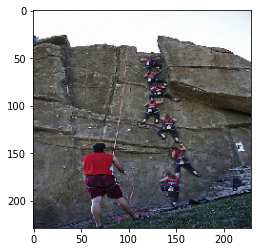

Predicted sentance :   man in red shirt is climbing rock <end>
Actual    sentance  :  brown dog chases the water from sprinkler on lawn 
Actual    sentance  :  brown dog plays with the hose 
Actual    sentance  :  brown dog running on lawn near garden hose 
Actual    sentance  :  dog is playing with hose 
Actual    sentance  :  large brown dog running away from the sprinkler in the grass 


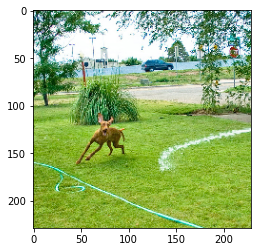

Predicted sentance :   brown dog is running through the grass <end>
Actual    sentance  :  dog prepares to catch thrown object in field with nearby cars 
Actual    sentance  :  white dog is about to catch yellow ball in its mouth 
Actual    sentance  :  white dog is about to catch yellow dog toy 
Actual    sentance  :  white dog is ready to catch yellow ball flying through the air 
Actual    sentance  :  white dog running after yellow ball 


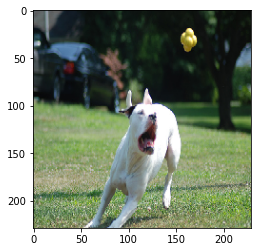

Predicted sentance :   white dog jumps to catch ball <end>


In [86]:
train_gen = generate_batch(X1_train_input,X2_train_input,y_train_output, batch_size = 1)
print_image_and_text(train_df,15,train_gen)

# Sample texts and Images from Test set

Actual    sentance  :  blond woman in blue shirt appears to wait for ride 
Actual    sentance  :  blond woman is on the street taxi 
Actual    sentance  :  woman is is to traffic as seen from behind 
Actual    sentance  :  the woman in the blue dress is holding out her arm at oncoming traffic 


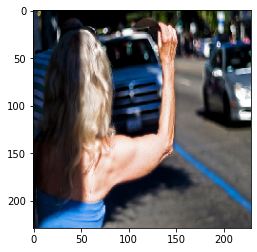

Predicted sentance :   boy with blue hair is sitting on the street <end>
Actual    sentance  :  boy in his blue swim shorts at the beach 
Actual    sentance  :  boy smiles for the camera at beach 
Actual    sentance  :  young boy in swimming trunks is walking with his arms outstretched on the beach 
Actual    sentance  :  children playing on the beach 
Actual    sentance  :  the boy is playing on the shore of an ocean 


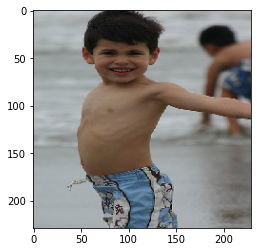

Predicted sentance :   boy in pink shorts is playing in the water <end>
Actual    sentance  :  lady and man with no shirt sit on dock 
Actual    sentance  :  man and woman are sitting on dock together 
Actual    sentance  :  man and woman sitting on dock 
Actual    sentance  :  man and woman sitting on deck next to lake 
Actual    sentance  :  shirtless man and woman sitting on dock 


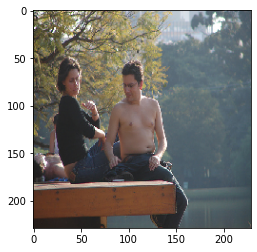

Predicted sentance :   man and woman sitting on bench <end>
Actual    sentance  :  closeup of white dog that is laying its head on its paws 
Actual    sentance  :  large white dog lying on the floor 
Actual    sentance  :  white dog has its head on the ground 
Actual    sentance  :  white dog is resting its head on tiled floor with its eyes open 
Actual    sentance  :  white dog rests its head on the patio bricks 


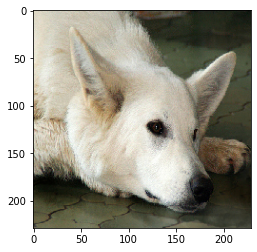

Predicted sentance :   white dog is running through the snow <end>
Actual    sentance  :  boy with toy gun 
Actual    sentance  :  little boy in orange shorts playing with toy 
Actual    sentance  :  young boy with his foot outstretched aims toy at the camera in front of fireplace 
Actual    sentance  :  young child plays with his new light up toy 
Actual    sentance  :  boy with toy gun pointed at the camera 


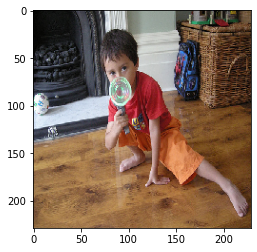

Predicted sentance :   boy in pink shirt plays with red ball <end>
Actual    sentance  :  black dog jumping to catch rope toy 
Actual    sentance  :  black dog playing fetch with ball of rope 
Actual    sentance  :  black dog pounces to get rope toy 
Actual    sentance  :  black dog running after his rope toy 
Actual    sentance  :  large black dog is playing in grassy yard 


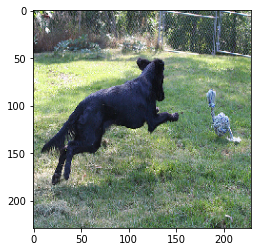

Predicted sentance :   black dog runs through the grass <end>
Actual    sentance  :  little tan dog with large ears running through the grass 
Actual    sentance  :  playful dog is running through the grass 
Actual    sentance  :  small dogs ears stick up as it runs in the grass 
Actual    sentance  :  the small dog is running across the lawn 
Actual    sentance  :  this is small beige dog running through grassy field 


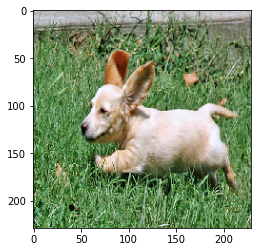

Predicted sentance :   two little dogs play with ball in the grass <end>
Actual    sentance  :  baby in white holds flag with and star 
Actual    sentance  :  baby is holding small black flag with and star on it 
Actual    sentance  :  baby wearing white gown waves flag 
Actual    sentance  :  little toddler dressed in white is smiling while lady helps him wave flag 
Actual    sentance  :  baby in white outfit holding black and white flag 


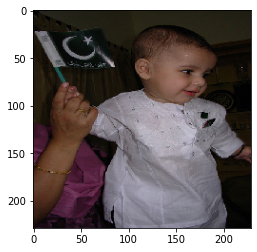

Predicted sentance :   young boy wearing white shirt is playing with his eyes <end>
Actual    sentance  :  brown and white dog stands outside while it snows 
Actual    sentance  :  dog is looking at something near the water 
Actual    sentance  :  furry dog attempts to dry itself by shaking the water off its coat 
Actual    sentance  :  white and brown dog shaking its self dry 
Actual    sentance  :  the large brown and white dog shakes off water 


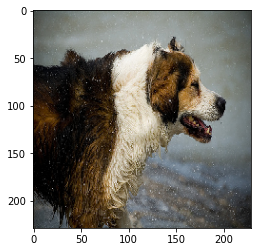

Predicted sentance :   dog with stick in its mouth <end>
Actual    sentance  :  boy is jumping on bed 
Actual    sentance  :  boy jumped up from the green bed 
Actual    sentance  :  boy jumps from one bed to another 
Actual    sentance  :  small child is jumping on bed 
Actual    sentance  :  the boy in blue shorts is bouncing on the bed 


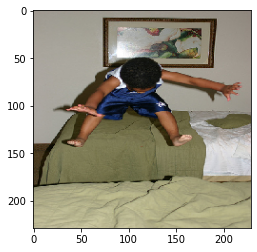

Predicted sentance :   young boy is jumping on the bed <end>
Actual    sentance  :  snowboarder sits on slope with skiers and nearby 
Actual    sentance  :  snowboarder takes rest on the mountainside 
Actual    sentance  :  snowboarders sitting in the snow while skiers take the hill 
Actual    sentance  :  the snowboarder is sitting down 
Actual    sentance  :  two skiers stand two sit on slopes 


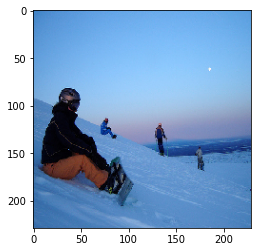

Predicted sentance :   man in winter gear is walking through the snow <end>
Actual    sentance  :  boy dressed in soccer attire and holding his shoes getting out of car 
Actual    sentance  :  boy in glasses is wearing red shirt 
Actual    sentance  :  child getting out of the car wearing soccer shoes 


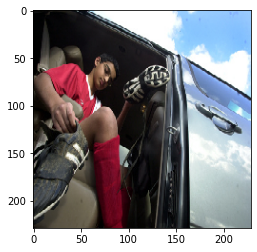

Predicted sentance :   boy in red shirt is sitting on the sidewalk <end>
Actual    sentance  :  three men are setting up sledge on snowy plain 
Actual    sentance  :  three men loading items on sled 
Actual    sentance  :  three people and sled 
Actual    sentance  :  three people are standing in the snow preparing an ice fishing boat 
Actual    sentance  :  three people in the snow put their gear in order 


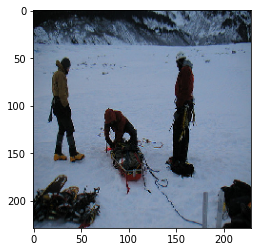

Predicted sentance :   two men are playing in the snow <end>
Actual    sentance  :  man in yellow 
Actual    sentance  :  man wearing yellow shirt with look on his face 
Actual    sentance  :  the man in the yellow shirt is pulling large grin on his face 
Actual    sentance  :  there is man wearing yellow shirt and grimacing 
Actual    sentance  :  this man is smiling very big at the camera 


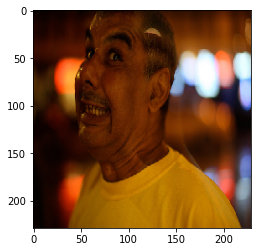

Predicted sentance :   man with glasses is holding her face <end>
Actual    sentance  :  girl in blue is jumping on the shore as small waves approach her 
Actual    sentance  :  girl leaps into the air while standing by the ocean 
Actual    sentance  :  young long haired girl on the beach is jumping in the air 
Actual    sentance  :  the girl is running into the ocean from the shore 
Actual    sentance  :  the girls is jumping into the air on the beach 


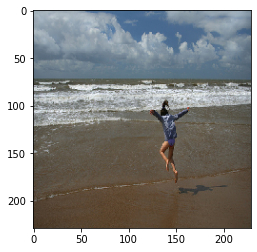

Predicted sentance :   boy in pink shorts is running into the water <end>


In [87]:
test_gen = generate_batch(X1_test_input,X2_test_input,y_test_output, batch_size = 1)
print_image_and_text(test_df,15,test_gen)